In [1]:
import torch
import numpy as np
from stochman import nnj
from stochman.hessian import MSEHessianCalculator, ArccosHessianCalculator, ContrastiveHessianCalculator

import matplotlib.pyplot as plt

/zhome/01/c/173531/miniconda3/envs/gauss/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
_input_size, _output_size = 400, 5

n_pos, n_neg = 4,5
ap = list(range(0,n_pos))
p = list(range(n_pos,2*n_pos))
an = list(range(2*n_pos,2*n_pos+n_neg))
n = list(range(2*n_pos+n_neg,2*n_pos+2*n_neg))
_batch_size = 2*n_pos+2*n_neg

tuple_indices = tuple((ap, p, an, n))
dataset = torch.randn(_batch_size, _input_size)


#dataset = torch.randn(20, 7)

In [3]:
architecture_type = 'conv'
assert architecture_type in ('easy', 'conv', 'resblock', 'resnet18', 'skipconnection')

use_bias = False #required for convolutions double point backprop

if architecture_type=='easy':
    stoch_model = nnj.Sequential(
                                nnj.Linear(_input_size, 30),
                                nnj.Tanh(),
                                nnj.Linear(30, 300),
                                nnj.ReLU(),
                                nnj.Linear(300, _output_size),
                                nnj.L2Norm(),
                                add_hooks = True
    )
elif architecture_type=='conv':
    stoch_model = nnj.Sequential(
                                nnj.Linear(_input_size, 32),
                                nnj.Tanh(),
                                nnj.Reshape(2, 4, 4),
                                nnj.Conv2d(2, 2, 3, stride=1, padding=1, bias=use_bias),
                                nnj.Flatten(),
                                nnj.ReLU(),
                                nnj.Linear(32, _output_size),
                                #nnj.L2Norm(),
                                add_hooks = True
    )
elif architecture_type=='resblock':
    stoch_model = nnj.Sequential(
                                nnj.Linear(_input_size, 13),
                                nnj.Tanh(),
                                nnj.ResidualBlock(
                                                nnj.Linear(13, 48),
                                                nnj.Tanh(),
                                                nnj.ResidualBlock(
                                                                nnj.Reshape(3, 4, 4),
                                                                nnj.Conv2d(3, 3, 3, stride=1, padding=1, bias=use_bias),
                                                                nnj.Flatten(),
                                                                add_hooks = True
                                                                ),
                                                nnj.Tanh(),
                                                nnj.Linear(48, 13),
                                                add_hooks = True
                                                ),
                                nnj.Tanh(),
                                nnj.Linear(13, 48),
                                nnj.Tanh(),
                                nnj.ResidualBlock(
                                                nnj.Reshape(3, 4, 4),
                                                nnj.Conv2d(3, 3, 3, stride=1, padding=1, bias=use_bias),
                                                nnj.Flatten(),
                                                add_hooks = True
                                                ),
                                nnj.Tanh(),
                                nnj.Linear(48, _output_size),
                                #nnj.L2Norm(),
                                add_hooks=True
                                )
elif architecture_type=='resnet18':
    inplanes, planes = 4, [8, 2, 3, 8]
    img_size = 10
    ratio = int(planes[3]/inplanes)
    stoch_model = nnj.Sequential(
                            #nnj.Linear(_input_size, inplanes * img_size * img_size),
                            nnj.Reshape(inplanes, img_size, img_size),
                            nnj.Conv2d(inplanes, planes[0], 7, stride=1, padding=3, bias=use_bias),
                            #nnj.MaxPool2d(2),
                            nnj.Flatten(), 
                            nnj.L2Norm(),
                            nnj.ReLU(),
                            nnj.Reshape(planes[0], img_size, img_size),
                            #nnj.MaxPool2d(3),
                            nnj.ResidualBlock(
                                            nnj.Conv2d(planes[0], planes[0], 3, stride=1, padding=1, bias=use_bias),
                                            #nnj.MaxPool2d(2),
                                            nnj.Flatten(), nnj.L2Norm(),
                                            nnj.ReLU(), nnj.Reshape(planes[0], img_size, img_size),
                                            nnj.Conv2d(planes[0], planes[0], 3, stride=1, padding=1, bias=use_bias),
                                            nnj.Flatten(), nnj.L2Norm(), nnj.Reshape(planes[0], img_size, img_size),
                                            add_hooks = True
                                            ),
                            nnj.Conv2d(planes[0], planes[1], 3, stride=1, padding=1, bias=use_bias),
                            nnj.ResidualBlock(
                                            nnj.Conv2d(planes[1], planes[1], 3, stride=1, padding=1, bias=use_bias),
                                            #nnj.MaxPool2d(2),
                                            nnj.Flatten(), nnj.L2Norm(), 
                                            nnj.ReLU(), nnj.Reshape(planes[1], img_size, img_size),
                                            nnj.Conv2d(planes[1], planes[1], 3, stride=1, padding=1, bias=use_bias),
                                            nnj.Flatten(), nnj.L2Norm(), nnj.Reshape(planes[1], img_size, img_size),
                                            add_hooks = True
                                            ),
                            nnj.Conv2d(planes[1], planes[2], 3, stride=1, padding=1, bias=use_bias),
                            nnj.ResidualBlock(
                                            nnj.Conv2d(planes[2], planes[2], 3, stride=1, padding=1, bias=use_bias),
                                            #nnj.MaxPool2d(2),
                                            nnj.Flatten(), nnj.L2Norm(),
                                            nnj.ReLU(), nnj.Reshape(planes[2], img_size, img_size),
                                            nnj.Conv2d(planes[2], planes[2], 3, stride=1, padding=1, bias=use_bias),
                                            nnj.Flatten(), nnj.L2Norm(), nnj.Reshape(planes[2], img_size, img_size),
                                            add_hooks = True
                                            ),
                            nnj.Conv2d(planes[2], planes[3], 3, stride=1, padding=1, bias=use_bias),
                            nnj.ResidualBlock(
                                            nnj.Conv2d(planes[3], planes[3], 3, stride=1, padding=1, bias=use_bias),
                                            #nnj.MaxPool2d(2),
                                            nnj.Flatten(), nnj.L2Norm(),
                                            nnj.ReLU(), nnj.Reshape(planes[3], img_size, img_size),
                                            nnj.Conv2d(planes[3], planes[3], 3, stride=1, padding=1, bias=use_bias),
                                            nnj.Flatten(), nnj.L2Norm(), nnj.Reshape(planes[3], img_size, img_size),
                                            add_hooks = True
                                            ),
                            #nnj.AdaptiveAVGPool2d,
                            nnj.Flatten(),
                            nnj.Linear(_input_size*ratio, _output_size),
                            add_hooks=True
                            )
elif architecture_type=='skipconnection':
    stoch_model = nnj.Sequential(
                                nnj.Linear(_input_size, 13),
                                nnj.Tanh(),
                                nnj.SkipConnection(
                                                   nnj.Linear(13, 48),
                                                   nnj.Tanh(),
                                                   nnj.SkipConnection(
                                                                      nnj.Reshape(3, 4, 4),
                                                                      nnj.Conv2d(3, 3, 3, stride=1, padding=1, bias=use_bias),
                                                                      nnj.Flatten(),
                                                                      add_hooks = True
                                                                      ),
                                                   nnj.Tanh(),
                                                   nnj.Linear(48*2, 13),
                                                   add_hooks = True
                                                   ),
                                nnj.Tanh(),
                                nnj.Linear(13*2, _output_size),
                                #nnj.L2Norm(),
                                add_hooks=True
                                )
stoch_model

Sequential(
  (0): Linear(in_features=400, out_features=32, bias=True)
  (1): Tanh()
  (2): Reshape()
  (3): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (4): Flatten()
  (5): ReLU()
  (6): Linear(in_features=32, out_features=5, bias=True)
)

# Forward

In [4]:
y = stoch_model(dataset)

In [5]:
y, j = stoch_model.forward(dataset, jacobian=True)
print(j.shape)

torch.Size([18, 5, 400])


torch.Size([18, 5, 5])


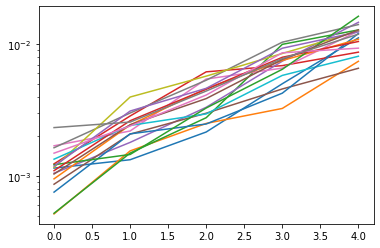

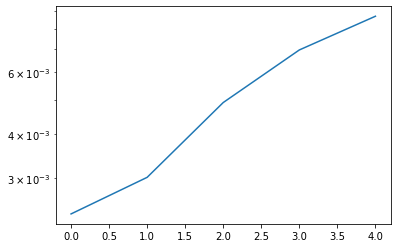

In [6]:
out_cov = torch.einsum("bij,bkj->bik",j,j)
print(out_cov.shape)

plt.figure()
for i in range(_batch_size):
    plt.plot(np.sort(torch.linalg.eig(out_cov[i])[0].real.detach().numpy()))
plt.yscale('log')
sum_cov = torch.mean(out_cov, dim=0)
plt.figure()
plt.plot(np.sort(torch.linalg.eig(sum_cov)[0].real.detach().numpy()))
plt.yscale('log')

# Single point

In [7]:
stoch_model.jTj(
    dataset, None,
    wrt="weight",
    to_diag=True,
    diag_backprop=True
)

stoch_model.jTj(
    dataset, None,
    wrt="input",
    to_diag=True,
    diag_backprop=True
)

tensor([[6.3631e-05, 5.4165e-05, 6.3966e-05,  ..., 4.7464e-05, 4.2256e-05,
         6.1924e-05],
        [4.5715e-05, 3.5091e-05, 4.9269e-05,  ..., 3.9763e-05, 2.9664e-05,
         4.2872e-05],
        [6.6793e-05, 5.5903e-05, 8.3202e-05,  ..., 6.7812e-05, 3.8177e-05,
         6.7612e-05],
        ...,
        [7.0767e-05, 4.4049e-05, 6.7222e-05,  ..., 6.8759e-05, 3.7928e-05,
         5.4645e-05],
        [5.9106e-05, 4.7383e-05, 7.5771e-05,  ..., 5.9473e-05, 4.7077e-05,
         6.8948e-05],
        [6.9903e-05, 6.3882e-05, 8.2432e-05,  ..., 6.2763e-05, 6.1483e-05,
         7.3470e-05]], grad_fn=<ViewBackward0>)

# MSE loss Hessian

In [8]:
h = MSEHessianCalculator(wrt = "weight")
hessian_wrt_weight = h.compute_hessian(dataset, stoch_model)
h = MSEHessianCalculator(wrt = "weight", speed="fast")
hessian_wrt_weight_approx = h.compute_hessian(dataset, stoch_model)

h = MSEHessianCalculator(wrt = "input")
hessian_wrt_input = h.compute_hessian(dataset, stoch_model)
h = MSEHessianCalculator(wrt = "input", speed="fast")
hessian_wrt_input_approx = h.compute_hessian(dataset, stoch_model)

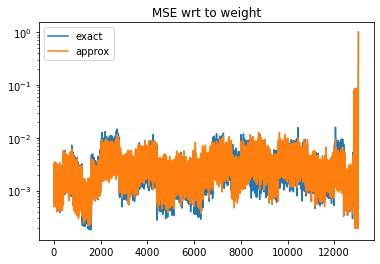

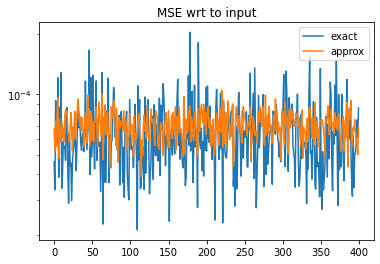

In [9]:
plt.plot(hessian_wrt_weight, label="exact")
plt.plot(hessian_wrt_weight_approx, label="approx")
plt.yscale('log')
plt.title('MSE wrt to weight')
plt.legend()

plt.figure()
plt.plot(hessian_wrt_input, label="exact")
plt.plot(hessian_wrt_input_approx, label="approx")
plt.yscale('log')
plt.title('MSE wrt to input')
plt.legend()

# Double point

In [10]:
stoch_model._jTmjp_batch2(
    dataset[ap], dataset[p],None, None,
    None,
    wrt="weight",
    to_diag=True,
    from_diag=False,diag_backprop=True
)

layer: Linear(in_features=32, out_features=5, bias=True)
layer: ReLU()
layer: Flatten()
layer: Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer: Reshape()
layer: Tanh()
layer: Linear(in_features=400, out_features=32, bias=True)


(tensor([[1.6160e-03, 3.4038e-04, 2.5357e-04,  ..., 1.0000e+00, 1.0000e+00,
          1.0000e+00],
         [3.7671e-03, 5.4141e-03, 1.0441e-04,  ..., 1.0000e+00, 1.0000e+00,
          1.0000e+00],
         [2.9454e-03, 2.0845e-04, 1.5971e-05,  ..., 1.0000e+00, 1.0000e+00,
          1.0000e+00],
         [3.3967e-03, 1.7908e-03, 2.6399e-03,  ..., 1.0000e+00, 1.0000e+00,
          1.0000e+00]], grad_fn=<CatBackward0>),
 tensor([[ 1.5687e-06, -1.1498e-05,  8.9107e-06,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [ 3.9720e-04,  2.2870e-04,  1.0991e-04,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [ 1.1075e-03, -1.0439e-04, -2.9160e-05,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-5.3877e-04, -2.7252e-04,  6.3314e-04,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00]], grad_fn=<CatBackward0>),
 tensor([[5.9974e-08, 1.5296e-05, 1.2332e-05,  ..., 1.0000e+00, 1.0000e+00,
          1.0000e+00],
         [1.6543e-04, 3.8161e-05,

# CONTRASTIVE loss Hessian

In [11]:
h = ContrastiveHessianCalculator(method = "fix")
hessian1 = h.compute_hessian(dataset, stoch_model, tuple_indices=tuple_indices)
print('fix - ',hessian1[:5], all(hessian1>0))

h = ContrastiveHessianCalculator(method = "full")
hessian2 = h.compute_hessian(dataset, stoch_model, tuple_indices=tuple_indices)
print('full - ',hessian2[:5], all(hessian2>0))

h = ContrastiveHessianCalculator(method = "pos")
hessian3 = h.compute_hessian(dataset, stoch_model, tuple_indices=tuple_indices)
print('pos - ',hessian3[:5], all(hessian3>0))

#print(all(hessian1>0), all(hessian2>0), all(hessian3>0))

fix -  tensor([ 0.0047, -0.0025, -0.0062, -0.0030, -0.0204]) False
layer: Linear(in_features=32, out_features=5, bias=True)
layer: ReLU()
layer: Flatten()
layer: Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer: Reshape()
layer: Tanh()
layer: Linear(in_features=400, out_features=32, bias=True)
layer: Linear(in_features=32, out_features=5, bias=True)
layer: ReLU()
layer: Flatten()
layer: Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer: Reshape()
layer: Tanh()
layer: Linear(in_features=400, out_features=32, bias=True)
full -  tensor([ 0.0041, -0.0009, -0.0078, -0.0009, -0.0146]) False
layer: Linear(in_features=32, out_features=5, bias=True)
layer: ReLU()
layer: Flatten()
layer: Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer: Reshape()
layer: Tanh()
layer: Linear(in_features=400, out_features=32, bias=True)
pos -  tensor([0.0136, 0.0085, 0.0074, 0.0027, 0.0195]) False


In [ ]:
plt.plot(hessian2, label='pos')
plt.plot(hessian3, label='full')
plt.plot(hessian1, label='fix')
plt.yscale('log')
plt.title('Contrastive')
plt.legend()

In [ ]:
h = ContrastiveHessianCalculator(method = "fix", speed="fast")
hessian1 = h.compute_hessian(dataset, stoch_model, tuple_indices=tuple_indices)
print('fix - ',hessian1[:5], all(hessian1>0))

h = ContrastiveHessianCalculator(method = "full", speed="fast")
hessian2 = h.compute_hessian(dataset, stoch_model, tuple_indices=tuple_indices)
print('full - ',hessian2[:5], all(hessian2>0))

h = ContrastiveHessianCalculator(method = "pos", speed="fast")
hessian3 = h.compute_hessian(dataset, stoch_model, tuple_indices=tuple_indices)
print('pos - ',hessian3[:5], all(hessian3>0))

fix -  tensor([-0.2021, -0.1417,  0.0921,  0.2496, -1.2073]) False


IndexError: too many indices for tensor of dimension 2

In [ ]:
plt.plot(hessian2, label='pos')
plt.plot(hessian3, label='full')
plt.plot(hessian1, label='fix')
plt.yscale('log')
plt.title('Contrastive - diag backpropagation')
plt.legend()

# ARCCOS loss Hessian

In [ ]:
h = ArccosHessianCalculator(method = "fix")
hessian1 = h.compute_hessian(dataset, stoch_model, tuple_indices=tuple_indices)
print('fix - ',hessian1[:5], all(hessian1>0))

h = ArccosHessianCalculator(method = "full")
hessian2 = h.compute_hessian(dataset, stoch_model, tuple_indices=tuple_indices)
print('full - ',hessian2[:5], all(hessian2>0))

h = ArccosHessianCalculator(method = "pos")
hessian3 = h.compute_hessian(dataset, stoch_model, tuple_indices=tuple_indices)
print('pos - ',hessian3[:5], all(hessian3>0))

print(all(hessian1>0), all(hessian2>0), all(hessian3>0))

In [ ]:
plt.plot(hessian2, label='pos')
plt.plot(hessian3, label='full')
plt.plot(hessian1, label='fix')
plt.yscale('log')
plt.title('Arccos')
plt.legend()

In [ ]:
h = ArccosHessianCalculator(method = "fix", speed="fast")
hessian1 = h.compute_hessian(dataset, stoch_model, tuple_indices=tuple_indices)
print('fix - ',hessian1[:5], all(hessian1>0))

h = ArccosHessianCalculator(method = "full", speed="fast")
hessian2 = h.compute_hessian(dataset, stoch_model, tuple_indices=tuple_indices)
print('full - ',hessian2[:5], all(hessian2>0))

h = ArccosHessianCalculator(method = "pos", speed="fast")
hessian3 = h.compute_hessian(dataset, stoch_model, tuple_indices=tuple_indices)
print('pos - ',hessian3[:5], all(hessian3>0))

print(all(hessian1>0), all(hessian2>0), all(hessian3>0))

In [ ]:
plt.plot(hessian2, label='pos')
plt.plot(hessian3, label='full')
plt.plot(hessian1, label='fix')
plt.yscale('log')
plt.title('Arccos - diag backpropagation')
plt.legend()

# U-Net

In [ ]:
UNet = nnj.Sequential(
                nnj.Conv2d(1, 64, 3, stride=1, padding=0),
                nnj.Conv2d(64, 64, 3, stride=1, padding=0),
                nnj.Flatten(),
                nnj.SkipConnection(
                                nnj.Reshape(1,64,392,392),
                                nnj.MaxPool2d(2),
                                nnj.Conv2d(64, 128, 3, stride=1, padding=0),
                                nnj.Conv2d(128, 128, 3, stride=1, padding=0),
                                nnj.Flatten(),
                                nnj.SkipConnection(
                                                nnj.MaxPool2d(2),
                                                nnj.Conv2d(128, 256, 3, stride=1, padding=0),
                                                nnj.Conv2d(256, 256, 3, stride=1, padding=0),
                                                nnj.Flatten(),
                                                nnj.SkipConnection(
                                                                nnj.MaxPool2d(2),
                                                                nnj.Conv2d(256, 512, 3, stride=1, padding=0),
                                                                nnj.Conv2d(512, 512, 3, stride=1, padding=0),
                                                                nnj.Flatten(),
                                                                nnj.SkipConnection(
                                                                                nnj.MaxPool2d(2),
                                                                                nnj.Conv2d(512, 1024, 3, stride=1, padding=0),
                                                                                nnj.Conv2d(1024, 1024, 3, stride=1, padding=0),
                                                                                nnj.Upsample(scale_factor=2),
                                                                                nnj.Flatten(),
                                                                                add_hooks=True
                                                                ),
                                                                nnj.Reshape(1,1024,56,56),
                                                                nnj.Conv2d(1024, 512, 3, stride=1, padding=0),
                                                                nnj.Conv2d(512, 512, 3, stride=1, padding=0),
                                                                nnj.Upsample(scale_factor=2),
                                                                nnj.Flatten(),
                                                                add_hooks=True
                                                ),
                                                nnj.Reshape(1,512,104,104),
                                                nnj.Conv2d(512, 256, 3, stride=1, padding=0),
                                                nnj.Conv2d(256, 256, 3, stride=1, padding=0),
                                                nnj.Upsample(scale_factor=2),
                                                nnj.Flatten(),
                                                add_hooks=True
                                ),
                                nnj.Reshape(1,256,200,200),
                                nnj.Conv2d(256, 128, 3, stride=1, padding=0),
                                nnj.Conv2d(128, 128, 3, stride=1, padding=0),
                                nnj.Upsample(scale_factor=2),
                                nnj.Flatten(),
                                add_hooks=True
                ),
                nnj.Reshape(1,128,392,392),
                nnj.Conv2d(128, 64, 3, stride=1, padding=0),
                nnj.Conv2d(64, 64, 3, stride=1, padding=0),
                nnj.Flatten(),
                nnj.Linear(64 * segmap_size, 2),
                add_hooks=True
        )